In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
train_path = '/content/drive/MyDrive/Dataset/train'
test_path = '/content/drive/MyDrive/Dataset/test'

In [12]:
seed()
folders = glob('/content/drive/MyDrive/Dataset/train/*')
print(len(folders))

2


In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [14]:
test_datagen = ImageDataGenerator(
    rescale=1./255)

In [15]:
train_set = train_datagen.flow_from_directory(train_path,
                                                target_size = (224, 224),
                                                batch_size=1,
                                                shuffle=False,
                                                 class_mode = 'categorical')

Found 4686 images belonging to 2 classes.


In [16]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            shuffle=False,
                                            batch_size=1,
                                            class_mode = 'categorical')

Found 1170 images belonging to 2 classes.


In [19]:
input_tensor=Input(shape=(224,224,3))

In [20]:
base_model1 = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
features1 = base_model1.output
for layer in base_model1.layers:
  layer.trainable=False
for layer in base_model1.layers:  
  layer._name = layer._name + str('_C')

In [21]:
base_model2 = VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)
features2 = base_model2.output
for layer in base_model2.layers:
  layer.trainable=False
for layer in base_model2.layers:  
  layer._name = layer._name + str('_D')

In [22]:
from tensorflow.keras.layers import concatenate
concatenated=concatenate([features1,features2]) 

In [23]:
Concatenated_model = Model(inputs=input_tensor, outputs=concatenated)

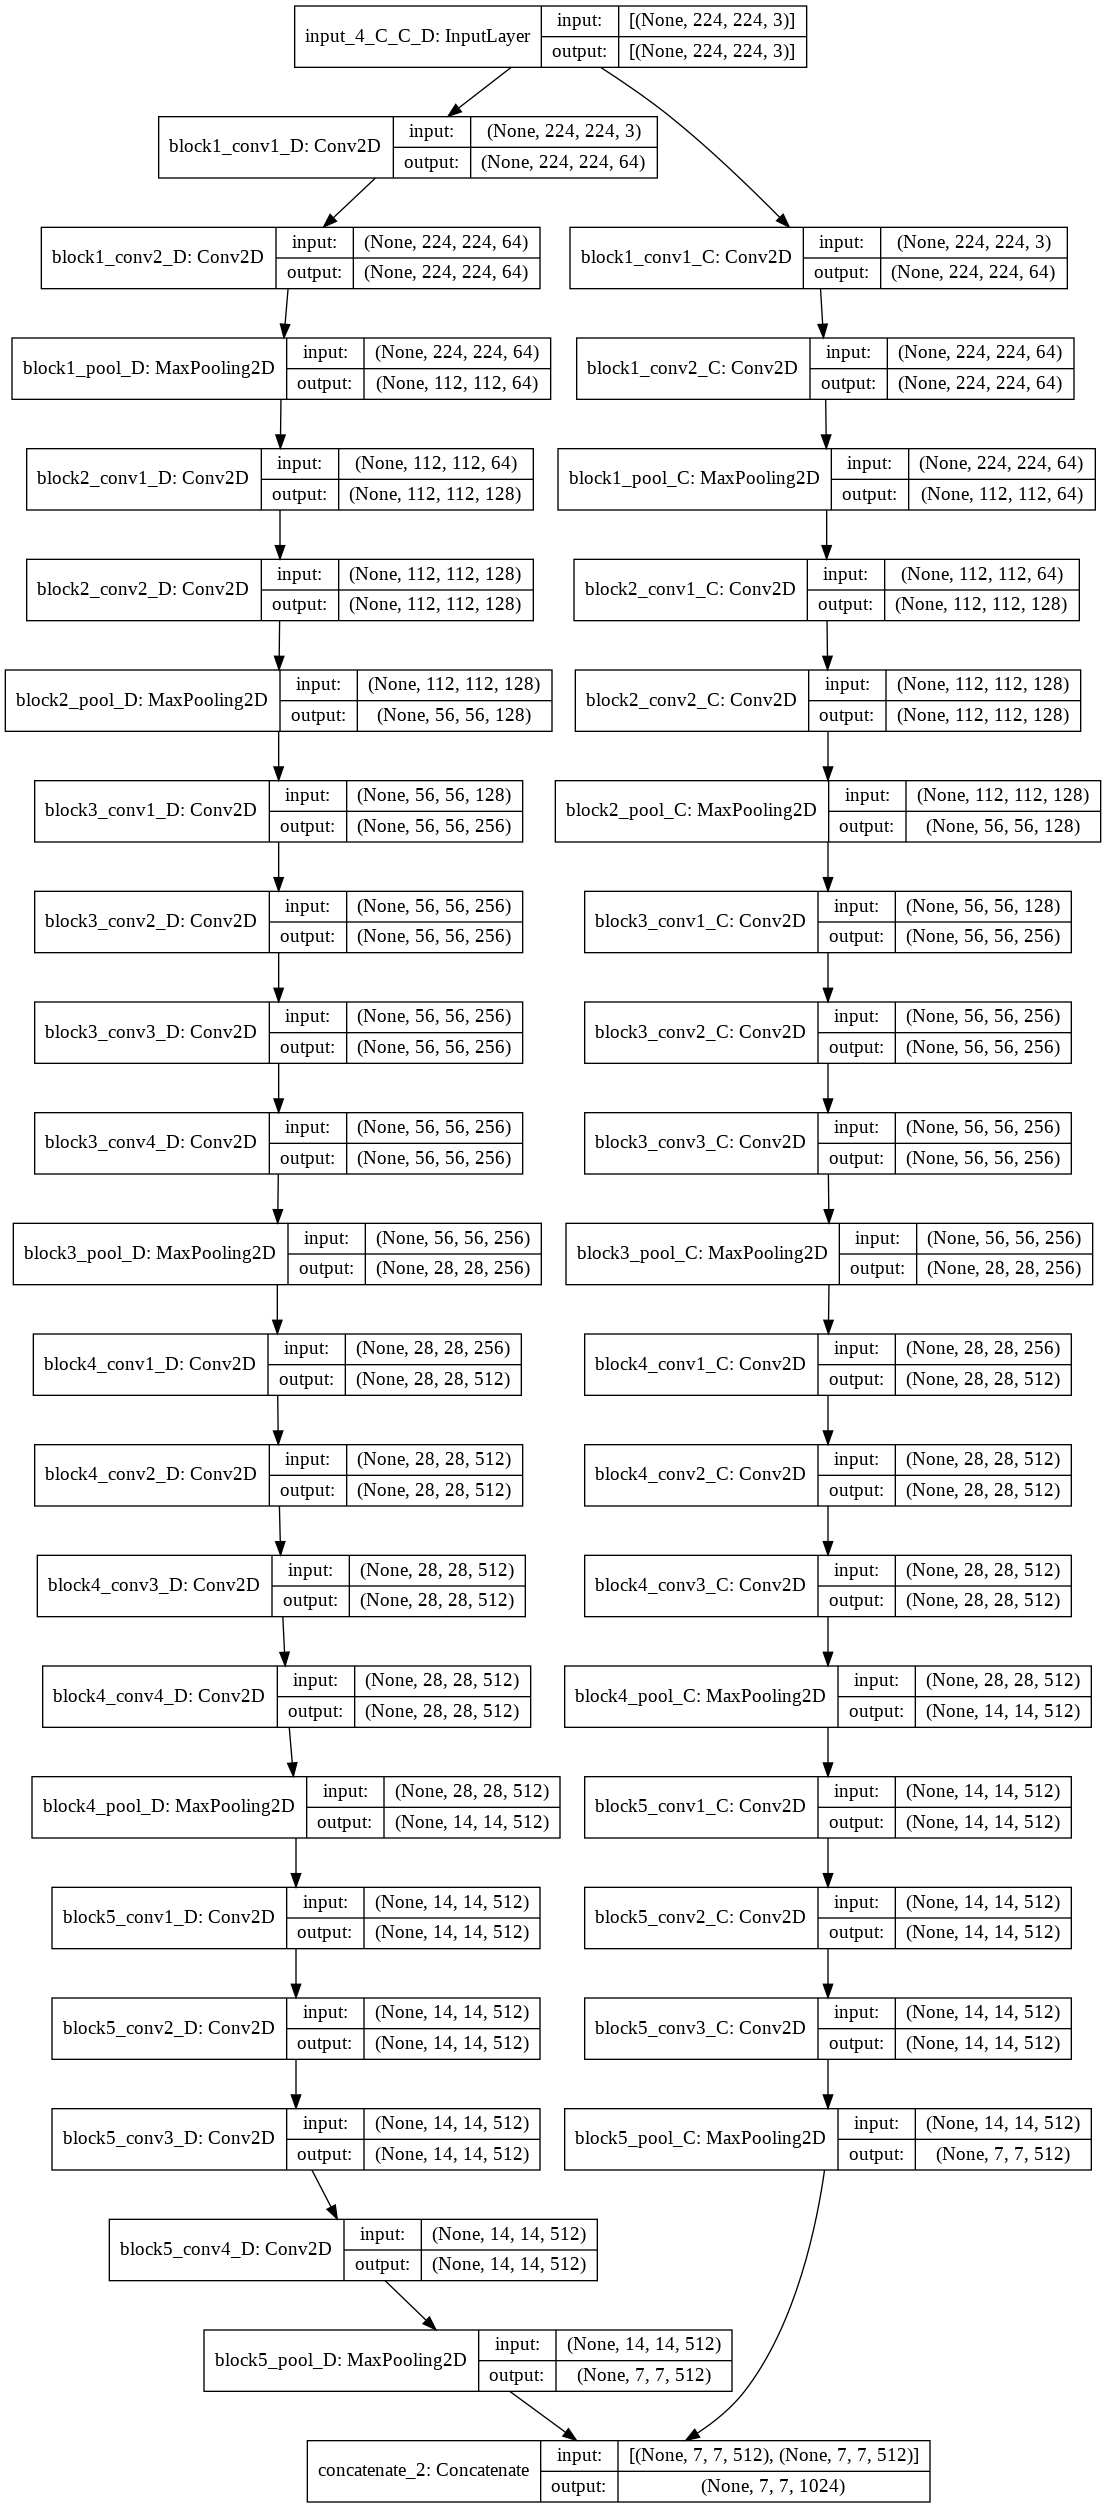

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(Concatenated_model, show_shapes=True)

In [ ]:
Concatenated_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4_C_C_D (InputLayer)      [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1_D (Conv2D)         (None, 224, 224, 64) 1792        input_4_C_C_D[0][0]              
__________________________________________________________________________________________________
block1_conv2_D (Conv2D)         (None, 224, 224, 64) 36928       block1_conv1_D[0][0]             
__________________________________________________________________________________________________
block1_pool_D (MaxPooling2D)    (None, 112, 112, 64) 0           block1_conv2_D[0][0]             
____________________________________________________________________________________________

In [24]:
features=Concatenated_model.predict(train_set, steps=4686, verbose=1)

4686/4686 [==============================] - 353s 69ms/step


In [25]:
features_flattened=[]
for i in features:
  a=i.ravel()
  features_flattened.append(a)

In [ ]:
from sklearn.svm import LinearSVC
svc=LinearSVC(C=1, dual=False, max_iter=6000)
model_svc=svc.fit(features_flattened, train_set.classes)

In [26]:
features_extracted_test=Concatenated_model.predict(test_set, steps=1170, verbose=1)

1170/1170 [==============================] - 81s 69ms/step


In [27]:
features_extracted_test_flattened=[]
for i in features_extracted_test:
  a=i.ravel()
  features_extracted_test_flattened.append(a)

In [ ]:
preds=model_svc.predict(features_extracted_test_flattened)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_test=test_set.classes
cf_matrix=confusion_matrix(y_test, preds)
print(cf_matrix)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds)


[[311   5]
 [ 42 812]]


0.9598290598290599

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest=RandomForestClassifier(random_state=0)
model_RF=random_forest.fit(features_flattened, train_set.classes)


In [ ]:
preds_RF=model_RF.predict(features_extracted_test_flattened)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_test=test_set.classes
cf_matrix=confusion_matrix(y_test, preds_RF)
print(cf_matrix)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds_RF)

[[291  25]
 [ 59 795]]


0.9282051282051282

In [ ]:
from sklearn.linear_model import LogisticRegression
logit=LogisticRegression(random_state=0, max_iter=6000)
model_logit=logit.fit(features_flattened, train_set.classes)


In [ ]:
preds_logit=model_logit.predict(features_extracted_test_flattened)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_test=test_set.classes
cf_matrix=confusion_matrix(y_test, preds_logit)
print(cf_matrix)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds_logit)

[[312   4]
 [ 45 809]]


0.9581196581196582

In [27]:
from sklearn.neighbors import KNeighborsClassifier
knn_optimized=KNeighborsClassifier(n_neighbors=7).fit(features_flattened, train_set.classes)

In [28]:
preds_knn=knn_optimized.predict(features_extracted_test_flattened)

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_test=test_set.classes
cf_matrix=confusion_matrix(y_test, preds_knn)
print(cf_matrix)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds_knn)

[[301  15]
 [ 74 780]]


0.923931623931624

In [31]:
from sklearn.naive_bayes import GaussianNB
classifier_NB=GaussianNB()
model_NB=classifier_NB.fit(features_flattened, train_set.classes)

In [32]:
preds_NB=model_NB.predict(features_extracted_test_flattened)

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_test=test_set.classes
cf_matrix=confusion_matrix(y_test, preds_NB)
print(cf_matrix)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds_NB)

[[205 111]
 [102 752]]


0.8179487179487179